<a href="https://colab.research.google.com/github/hsssj4/artificial_intelligence/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [47]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


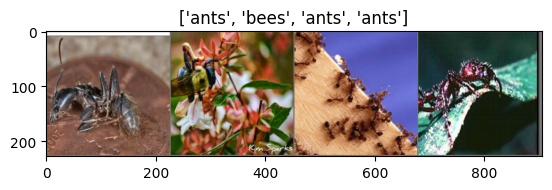

In [48]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [49]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [50]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [51]:
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [52]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.6972 Acc: 0.3689
val Loss: 2.6553 Acc: 0.4902

Epoch 1/24
----------
train Loss: 0.6132 Acc: 0.7623
val Loss: 1.5469 Acc: 0.7516

Epoch 2/24
----------
train Loss: 0.3937 Acc: 0.8566
val Loss: 0.7117 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.3722 Acc: 0.8402
val Loss: 0.7094 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.4065 Acc: 0.8156
val Loss: 0.6572 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.3580 Acc: 0.8279
val Loss: 0.5995 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.3126 Acc: 0.8443
val Loss: 0.4914 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3350 Acc: 0.8566
val Loss: 0.4423 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.2851 Acc: 0.8934
val Loss: 0.4218 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.3115 Acc: 0.8893
val Loss: 0.4680 Acc: 0.8693

Epoch 10/24
----------
train Loss: 0.3534 Acc: 0.8607
val Loss: 0.4189 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.4643 Acc: 0.8115
val Loss: 0.7743 Acc: 0.8562

Ep

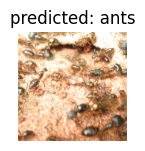

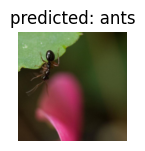

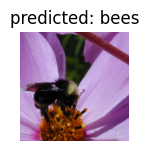

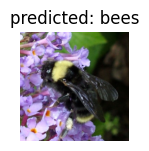

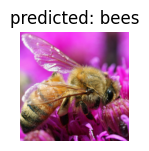

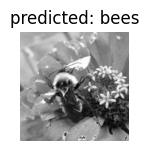

In [53]:
visualize_model(model_ft)

In [63]:
model_conv = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [64]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6097 Acc: 0.6844
val Loss: 0.4784 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4618 Acc: 0.7992
val Loss: 0.3795 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4261 Acc: 0.8279
val Loss: 0.3495 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4115 Acc: 0.8197
val Loss: 0.3288 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.3878 Acc: 0.8402
val Loss: 0.3074 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4060 Acc: 0.8279
val Loss: 0.3286 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4173 Acc: 0.8197
val Loss: 0.3168 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3863 Acc: 0.8115
val Loss: 0.3166 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.3964 Acc: 0.8320
val Loss: 0.3245 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.3693 Acc: 0.8402
val Loss: 0.2960 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.4039 Acc: 0.7951
val Loss: 0.4324 Acc: 0.8693

Epoch 11/24
----------
train Loss: 0.4263 Acc: 0.8033
val Loss: 0.3141 Acc: 0.8824

Epoch 12/24
----------
t

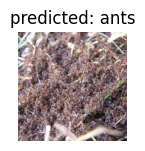

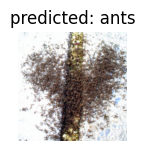

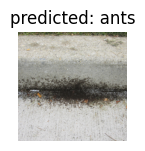

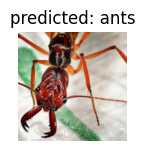

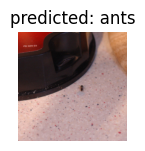

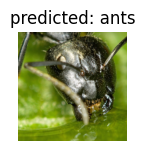

In [65]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [66]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

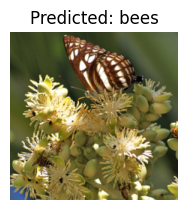

In [68]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()